In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append("..")

from Configs import getEnvConfig, visualizeEnvConfig
from Environment.EnvironmentSim import createEnv
from Environment.Helpers.Simulators import SimulatorType1, SimulatorType2
from Environment.RewardFuntions import RewardKernel, Type1RewardKernel, Type2RewardKernel
from Agents.Others import PolicyDemoAdaptiveAlpha

In [2]:
configIdx = 2
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
trafficDataParentPath = f'../Datasets/TrafficDataset/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="train", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
Resource Bar:           5
Bandwidth:              100
Sub Agents:             [[0]]
User Map:               [[0, 1, 2, 3]]


In [3]:

envParams['alpha_range'] = [0.1, 0.1]
envParams['discrete_alpha_steps'] = 100
envParams['B'] = 100

rewardKernel = RewardKernel(envParams)

policy = PolicyDemoAdaptiveAlpha(envParams)
M_fixed = 4

In [4]:
N_iter = 5000

metrics = {'Analytical': [], 'Simulation': []}

for alpha_fixed in np.linspace(0.1, 0.7, 10):
    env.reset()
    total_u = 0
    failed_u = 0
    for i in range(N_iter):
        env.updateStates()
        u, _ = env.getStates()
        w, r, _ = policy.getActionsByGivenAlpha(u, alpha_fixed)
        env.applyActions(w, r, M_fixed, alpha_fixed)
        reward_Jtype1 = rewardKernel.Type1RewardKernel.getReward(u, w, r)
        reward_Jtype2 = rewardKernel.Type2RewardKernel.getReward(u, w, M_fixed, alpha_fixed)
        total_u += np.sum(u)
        failed_u += (np.sum(w*u)*reward_Jtype1 + np.sum((1-w)*u)*reward_Jtype2)
        #print(u, w, reward_Jtype1, reward_Jtype2)
    packetLossRate_simulation = env.getPacketLossRate()
    packetLossRate_analytical = failed_u/total_u
    metrics['Analytical'].append(packetLossRate_analytical)
    metrics['Simulation'].append(packetLossRate_simulation)
    print(f'Analytical: {packetLossRate_analytical}')
    print(f'Simulation: {packetLossRate_simulation}')

Analytical: 0.03811696790607389
Simulation: 0.03790810192766689
Analytical: 0.022606746082445676
Simulation: 0.022323943314605906
Analytical: 0.016100355043084272
Simulation: 0.015911198815984212
Analytical: 0.014348198218309618
Simulation: 0.01398475175496078
Analytical: 0.012922956539171115
Simulation: 0.012377463404743149
Analytical: 0.012429663138364511
Simulation: 0.012038039733013053
Analytical: 0.015119255604648267
Simulation: 0.014331224165620857
Analytical: 0.01730423935370077
Simulation: 0.016314427081437346
Analytical: 0.02136662831949377
Simulation: 0.0198478741067624
Analytical: 0.0293246088256114
Simulation: 0.026766223262242043



                   MODEL ACCURACY METRICS                   
Mean Absolute Error (MAE):          0.000784
Root Mean Square Error (RMSE):      0.001058
Maximum Error:                      0.002558
Average Relative Error:             3.93%


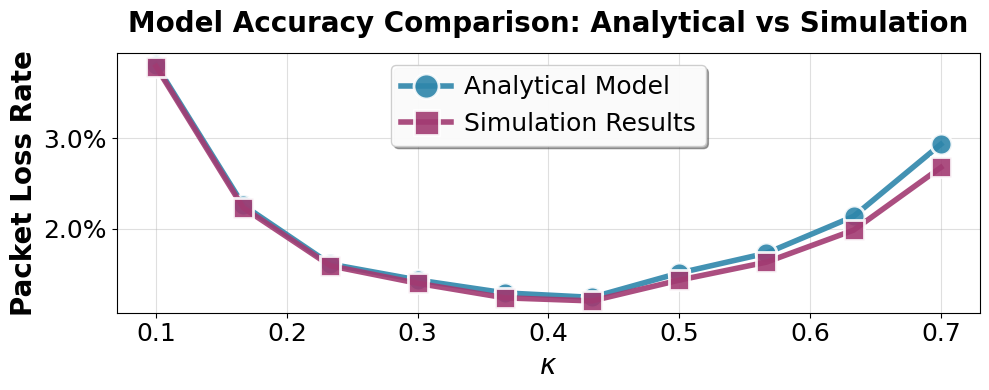

In [26]:
# Enhanced visualization with bigger fonts, markers, and condensed layout
plt.figure(figsize=(10, 4))

# Create alpha values for x-axis
alpha_values = np.linspace(0.1, 0.7, 10)

# Plot both metrics with larger markers and thicker lines
plt.plot(alpha_values, metrics['Analytical'], 
         marker='o', linewidth=4, markersize=15, 
         label='Analytical Model', color='#2E86AB', alpha=0.9, markeredgewidth=2, markeredgecolor='white')

plt.plot(alpha_values, metrics['Simulation'], 
         marker='s', linewidth=4, markersize=15, 
         label='Simulation Results', color='#A23B72', alpha=0.9, markeredgewidth=2, markeredgecolor='white')

# Add grid for better readability
plt.grid(True, alpha=0.4, linestyle='-', linewidth=0.8)

# Customize axes with bigger fonts
plt.xlabel('$\kappa$', fontsize=20, fontweight='bold')
plt.ylabel('Packet Loss Rate', fontsize=20, fontweight='bold')
plt.title('Model Accuracy Comparison: Analytical vs Simulation', 
          fontsize=20, fontweight='bold', pad=15)

# Add legend with bigger font
plt.legend(fontsize=18, loc='upper center', framealpha=0.95, shadow=True, 
           markerscale=1.2, handletextpad=0.5)

# Format y-axis to show percentages with bigger font
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.tick_params(axis='both', which='major', labelsize=18)

# Add some padding around the plot
plt.tight_layout()

#plt.show()
plt.savefig('C:/Users/Ye/Documents/YuYeh_Documents/L2S/Conference_Writing/ICC_diffusion_policy/Figures/fig05_model_accuracy.png', dpi=300)

# Calculate and display accuracy metrics with bigger fonts
mae = np.mean(np.abs(np.array(metrics['Analytical']) - np.array(metrics['Simulation'])))
mse = np.mean((np.array(metrics['Analytical']) - np.array(metrics['Simulation']))**2)
rmse = np.sqrt(mse)
max_error = np.max(np.abs(np.array(metrics['Analytical']) - np.array(metrics['Simulation'])))

print(f"\n{'='*60}")
print(f"{'MODEL ACCURACY METRICS':^60}")
print(f"{'='*60}")
print(f"{'Mean Absolute Error (MAE):':<35} {mae:.6f}")
print(f"{'Root Mean Square Error (RMSE):':<35} {rmse:.6f}")
print(f"{'Maximum Error:':<35} {max_error:.6f}")
print(f"{'Average Relative Error:':<35} {mae/np.mean(metrics['Analytical'])*100:.2f}%")
print(f"{'='*60}")